# The Unsent Project Text-To-Color Classification

In this part of the project, I wanted to learn text classification with deep learning. I've already seen naive bayes and logistic regression in action, and used them in previous projects. I wanted to try something new, and not only make a cool tool for people to test out, but also see if training a semi-accurate model would reveal anything about the data.

## Import Packages

In [3]:
import pandas as pd
import numpy as np
import keras

from collections import defaultdict, Counter
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

## Import the data

In [4]:
df = pd.read_csv('D:/Coding/Projects/Python/The Unsent Project/unsent_data_final.csv')

In [5]:
df.head()

,name,date,color,message
0,Evan,June 30 2020,Tangerine,All I want is you to be happy. I love you fore...
1,Procureur,June 30 2020,Light Pink,Tu es mon meilleur ami\\n\n
2,shiv,June 30 2020,Pale Purple,i loved you more than you ever cared for me. i...
3,brendan,June 30 2020,Yellow,you make me so incredibly happy & im so in lov...
4,James,June 30 2020,Yellow,There this thing about you. No matter how many...


## Get down to business

## Base model: Multinomial Naive Bayes

In [33]:
features = ['message']
X = df[features]
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(X['message'].apply(str))
#vectors.shape
y = df['color']

train_X, val_X, train_y, val_y = train_test_split(vectors, y, random_state=1) # by default does train:test 75:25

In [34]:
base_clf = MultinomialNB()
base_clf.fit(train_X, train_y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [26]:
#from sklearn.pipeline import Pipeline
#base_pipeline = Pipeline([('vect', CountVectorizer()), ('clf', MultinomialNB())])
#base_pipeline.

In [66]:
test = [input()]
test_vec = vectorizer.transform(test)
base_clf.predict(test_vec)

I want to eat instant noodles at 4am with you.


array(['Pale Blue'], dtype='<U12')

I tested some messages, and it is overfitted to the amount of black entries there have been. One fault of NB in this situation is that it takes into account the document probability, which may be more accurate in predicting real submissions, but for my purposes, when people are using this to just see what it'll say, the document probability should be fairly well-rounded. This is a part of overfitting that a more advanced (deep learning) model will likely handle better)

In [55]:
# Evaluation
score = base_clf.score(val_X, val_y)
'Accuracy: ', score

('Accuracy: ', 0.15053118060140447)

Wow that is very very low. On one part, that could mean that the words alone do not characterize the color of a message very well. Good thing we can use more advanced models, that can include more features, like the name and the order of words!

In [57]:
1 / len(set(df['color']))

0.03225806451612903

I just wanted to compare it to if it just geussed randomly/a single color the whole time, and so it does perform better than that, but it is still quite low.

## Backup model: Naive bayes without document probability
This is for if I can't get the neural network to work, I'll still have a model that can work for possibly deploying on a webpage, and not have the model be overly weighted towards any single color.

I'm achieving this by just coding my own naive bayes from scratch (with laplace smoothing) and not including document probability, which in effect should work similar to if I oversampled each of the colors in equal distribution to have equal amounts of documents.

In [6]:
color_word_counts = defaultdict(lambda: Counter())
for i, row in df.iterrows():
    color = row['color']
    message = str(row['message'])
    counts = Counter(word_tokenize(message.lower()))
    color_word_counts[color] += counts

In [7]:
color_word_probs = {}
for color in color_word_counts:
    counts = color_word_counts[color]
    n_words = sum(list(counts.values()))
    probs = defaultdict(lambda: 1 / (n_words + 1))
    for word in counts:
        probs[word] = counts[word] / (n_words + 1)
    color_word_probs[color] = probs

In [8]:
color_word_probs

{'Tangerine': defaultdict(<function __main__.<lambda>()>,
             {'all': 0.003705277696618768,
              'i': 0.07057292358362773,
              'want': 0.0032138967834471036,
              'is': 0.003359983000876517,
              'you': 0.06993545645302664,
              'to': 0.02285585274509283,
              'be': 0.006441074132115063,
              'happy': 0.0018725596961406677,
              '.': 0.054769050970809315,
              'love': 0.013214162394751521,
              'forever.\\\\\\\\n\\\\r\\\\n\\r\\n': 3.98416956625674e-05,
              'im': 0.00922999282849478,
              'over': 0.0012483731307604451,
              'now': 0.002722515870275439,
              'we': 0.008180828176047173,
              'werent': 0.0005710643044967993,
              'perfect': 0.000265611304417116,
              'but': 0.010637732741905496,
              'will': 0.003174055087784536,
              'always': 0.003784961087943903,
              'have': 0.005604398523201147,
 

In [9]:
def model(sentence):
    sentence = sentence.lower()
    words = word_tokenize(sentence)
    color_probs = {}
    for color in color_word_probs:
        prob = 1.0
        for word in words:
            prob *= color_word_probs[color][word]
        color_probs[color] = prob
    most_likely_color = max(color_probs.keys(), key = lambda x: color_probs[x])
    return most_likely_color

In [10]:
model(input())

I want to eat noodles at 4am with you.


'Brown'

## Experimental Model: Keras Sequential Model Using GloVe Word Embeddings
Here I am just trying to test out using deep learning because this is my first real experience using them.

In [6]:
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [27]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [29]:
# organize training and test data
sentences = df['message'][:10000]
color_labels = df['color'][:10000]

In [30]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, color_labels, test_size=0.25, random_state=8)

In [31]:
colors = ['Army Green','Black','Blue','Blue Grey','Brown','Dark Blue','Dark Green','Dark Purple','Green','Grey',\
          'Light Blue','Light Green','Light Grey','Light Orange','Light Pink','Light Purple','Maroon','Orange',\
          'Pale Blue','Pale Pink','Pale Purple','Peach','Pink','Purple','Red','Tan','Tangerine','Turquoise','White',\
          'Wine','Yellow']
color_key = {color:colors.index(color) for color in colors}

In [32]:
#extend_ans = lambda color: [1 if color == other_color else 0 for other_color in colors]
extend_ans = lambda color: color_key[color]
y_train = [extend_ans(color) for color in y_train]
y_test = [extend_ans(color) for color in y_test]

In [33]:
#df.color.astype('category').cat.codes
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [34]:
sentences_train, sentences_test = [str(sent) for sent in sentences_train], [str(sent) for sent in sentences_test]

In [35]:
tokenizer = Tokenizer(num_words=5000) # i don't know what num_words is
tokenizer.fit_on_texts(sentences_train)

In [36]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

In [38]:
print(sentences_train[2])
print(X_train[2])

dani\\n\n
[1934, 1, 1]


In [39]:
maxlen = 100 # arbitrary
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [40]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [41]:
embedding_dim = 50 # literally have no idea why this is
embedding_matrix = create_embedding_matrix('D:/Coding/Projects/Python/The Unsent Project/glove_word_embeddings/glove.6B.50d.txt', tokenizer.word_index, embedding_dim)

In [42]:
vocab_size = len(tokenizer.word_index) + 1
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.8707394300614639

In [43]:
n_colors = len(set(df['color']))
n_colors

31

In [44]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(50, activation='relu')) # I just picked a number a bit bigger than my final, 31
model.add(layers.Dense(n_colors, activation='softmax')) # an article told me to choose softmax to make it a probability basically
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           268450    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 31)                1581      
Total params: 272,581
Trainable params: 4,131
Non-trainable params: 268,450
_________________________________________________________________


In [45]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=31)

Training Accuracy: 0.1787
Testing Accuracy:  0.1632


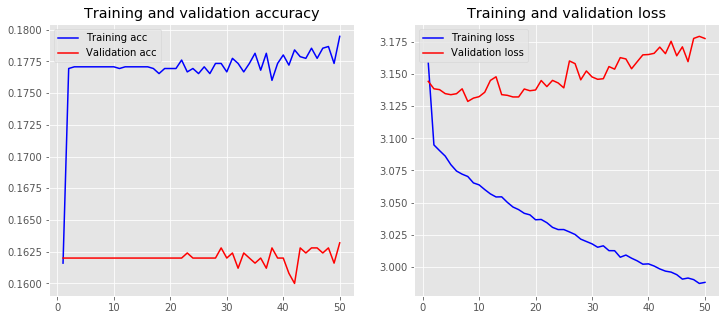

In [46]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)